In [ ]:
"""

Date: November 23, 2022

Author: Karine Choquet

This script will make datasets and plots for Fig 3 of the splicing order manuscript


"""

In [1]:
import numpy as np
import pandas as pd
import pysam
from collections import Counter

import matplotlib.pyplot as plt
import re
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

import math

from tqdm import tqdm

import pybedtools
from pybedtools import BedTool

import seaborn as sns
sns.set_style("white")

import scipy
from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr

import random
from numpy.random import choice

import itertools

import upsetplot
from upsetplot import plot
from upsetplot import generate_counts

In [2]:
# Load intron features and gene_names df
hg38_intron_df = pd.read_table("/path/to/annotation_files/hg38_all_intron_features.txt")
gene_names_df = pd.read_table("/path/to/annotation_files/hg38_UCSC_refGene_names.txt")
gene_names_df.columns = ['gene_name','gene_id']

hg38_intron_df['gene_id'] = hg38_intron_df['gene'].str.split("\\.").str[0]

hg38_intron_df = hg38_intron_df.merge(gene_names_df, on='gene_id')

hg38_intron_coord = hg38_intron_df.copy()[['chrom','start','end','gene','intron_pos']]

In [3]:
# Function to remove duplicate intron groups (same coordinates but different transcript)
def remove_duplicate_introns(path_df_tmp):
    
    path_df = path_df_tmp[['sample_name','gene','gene_name','analyzed_introns','n_analyzed_introns','full_path','full_path_score','rank']].drop_duplicates().sort_values(by=['gene_name','analyzed_introns','rank']).reset_index(drop=True)
    
    # Remove duplicates intron groups because they belong to different transcripts
    intron_groups = path_df[['gene','gene_name','analyzed_introns','n_analyzed_introns']].drop_duplicates().reset_index(drop=True)

    intron_groups_3 = intron_groups[intron_groups['n_analyzed_introns']==3].reset_index(drop=True)
    intron_groups_3['int1'] = intron_groups_3['analyzed_introns'].str.split("_").str[0].astype(int)
    intron_groups_3['int2'] = intron_groups_3['analyzed_introns'].str.split("_").str[1].astype(int)
    intron_groups_3['int3'] = intron_groups_3['analyzed_introns'].str.split("_").str[2].astype(int)

    intron_groups_3 = intron_groups_3.merge(hg38_intron_coord, left_on=['gene','int1'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_1', 'start':'start_1', 'end':'end_1'})
    intron_groups_3 = intron_groups_3.merge(hg38_intron_coord, left_on=['gene','int2'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_2', 'start':'start_2', 'end':'end_2'})
    intron_groups_3 = intron_groups_3.merge(hg38_intron_coord, left_on=['gene','int3'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_3', 'start':'start_3', 'end':'end_3'})

    intron_groups_3 = intron_groups_3.sort_values(by=['gene','int1','int2','int3']).drop_duplicates(subset=['chrom_1','start_1','end_1','chrom_2','start_2','end_2','chrom_3','start_3','end_3']).reset_index(drop=True)
    
    
    intron_groups_4 = intron_groups[intron_groups['n_analyzed_introns']==4].reset_index(drop=True)
    intron_groups_4['int1'] = intron_groups_4['analyzed_introns'].str.split("_").str[0].astype(int)
    intron_groups_4['int2'] = intron_groups_4['analyzed_introns'].str.split("_").str[1].astype(int)
    intron_groups_4['int3'] = intron_groups_4['analyzed_introns'].str.split("_").str[2].astype(int)
    intron_groups_4['int4'] = intron_groups_4['analyzed_introns'].str.split("_").str[3].astype(int)

    intron_groups_4 = intron_groups_4.merge(hg38_intron_coord, left_on=['gene','int1'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_1', 'start':'start_1', 'end':'end_1'})
    intron_groups_4 = intron_groups_4.merge(hg38_intron_coord, left_on=['gene','int2'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_2', 'start':'start_2', 'end':'end_2'})
    intron_groups_4 = intron_groups_4.merge(hg38_intron_coord, left_on=['gene','int3'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_3', 'start':'start_3', 'end':'end_3'})
    intron_groups_4 = intron_groups_4.merge(hg38_intron_coord, left_on=['gene','int4'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_4', 'start':'start_4', 'end':'end_4'})

    intron_groups_4 = intron_groups_4.sort_values(by=['gene','int1','int2','int3']).drop_duplicates(subset=['chrom_1','start_1','end_1','chrom_2','start_2','end_2','chrom_3','start_3','end_3','chrom_4','start_4','end_4']).reset_index(drop=True)
    
    fields = ['gene','gene_name','analyzed_introns','n_analyzed_introns']
    intron_groups_nodup = pd.concat([intron_groups_3[fields],intron_groups_4[fields]]).sort_values(by=['gene_name','analyzed_introns']).reset_index(drop=True)

    # Merge back with paths
    path_df_tmp_nodup = path_df_tmp.merge(intron_groups_nodup, on=['gene','gene_name','analyzed_introns','n_analyzed_introns'])
    path_df_nodup = path_df_tmp_nodup[['sample_name','gene','gene_name','analyzed_introns','n_analyzed_introns','full_path','full_path_score','rank']].drop_duplicates().sort_values(by=['gene_name','analyzed_introns','rank']).reset_index(drop=True)
    
    return(path_df_nodup)



In [4]:
# Get splicing orders per replicate for HeLa cells, remove duplicates, and write to a new file for further plotting in R
HeLa_by_rep_paths_tmp = pd.read_table("/path/to/HeLa_chromatin_splicing_paths_non_consecutive_introns.RefSeq.min10.3_introns.txt")
HeLa_by_rep_path_df_nodup = remove_duplicate_introns(HeLa_by_rep_paths_tmp)

HeLa_by_rep_path_df_nodup.to_csv("/path/to/HeLa_splicing_order_paths_by_rep_nodup.txt", sep="\t", header=True, index=False)


In [5]:
# Get splicing orders per replicate for MN D9, remove duplicates, and write to a new file for further plotting in R
D9_by_rep_paths_tmp = pd.read_table("/path/to/MN_D9_chromatin_splicing_paths_non_consecutive_introns.RefSeq.min10.3_introns.reps_each.txt")
D9_by_rep_path_df_nodup = remove_duplicate_introns(D9_by_rep_paths_tmp)

D9_by_rep_path_df_nodup.to_csv("/path/to/D9_splicing_order_paths_by_rep_nodup.txt", sep="\t", header=True, index=False)


In [6]:
# Get splicing orders per replicate for MN D14, remove duplicates, and write to a new file for further plotting in R
D14_by_rep_paths_tmp = pd.read_table("/path/to/MN_D14_chromatin_splicing_paths_non_consecutive_introns.RefSeq.min10.3_introns.reps_each.txt")
D14_by_rep_path_df_nodup = remove_duplicate_introns(D14_by_rep_paths_tmp)

D14_by_rep_path_df_nodup.to_csv("/path/to/D14_splicing_order_paths_by_rep_nodup.txt", sep="\t", header=True, index=False)


In [7]:
# Get splicing orders from combined replicates for all cell types
D9_paths_tmp = pd.read_table("/path/to/MN_D9_chrRNA_merged_chromatin_splicing_paths_non_consecutive_introns.RefSeq.min10.3_introns.reps_merged.txt")
D14_paths_tmp = pd.read_table("/path/to/MN_D14_chrRNA_merged_chromatin_splicing_paths_non_consecutive_introns.RefSeq.min10.3_introns.reps_merged.txt")
K562_paths_tmp = pd.read_table("/path/to/K562_chromatin_splicing_paths_non_consecutive_introns.RefSeq.min10.3_introns.reps_merged.txt")
HeLa_paths_tmp = pd.read_table("/path/to/HeLa_chromatin_splicing_paths_non_consecutive_introns.RefSeq.min10.3_introns.reps_merged.txt")

D9_paths_tmp['sample_name'] = 'D9'
D14_paths_tmp['sample_name'] = 'DMN'
K562_paths_tmp['sample_name'] = 'K562'
HeLa_paths_tmp['sample_name'] = 'HeLa'

In [8]:
# Remove duplicate intron groups
D9_path_df_nodup = remove_duplicate_introns(D9_paths_tmp)
D14_path_df_nodup = remove_duplicate_introns(D14_paths_tmp)
K562_path_df_nodup = remove_duplicate_introns(K562_paths_tmp)
HeLa_path_df_nodup = remove_duplicate_introns(HeLa_paths_tmp)

In [11]:
# Write HeLa orders to file for further plotting in R
HeLa_path_df_nodup.to_csv("/path/to/HeLa_splicing_order_paths_reps_merged_nodup.txt", sep="\t", header=True, index=False)


In [12]:
# Concatenate splicing orders from all cell types
path_df_all = pd.concat([D9_path_df_nodup,D14_path_df_nodup,K562_path_df_nodup,HeLa_path_df_nodup]).reset_index(drop=True)
path_df_all_piv = path_df_all[['gene_name','gene','analyzed_introns','sample_name','n_analyzed_introns']].drop_duplicates().pivot_table(index=['gene','gene_name','analyzed_introns'],columns='sample_name', values='n_analyzed_introns').dropna().reset_index()
covered_regions = path_df_all_piv[['gene','gene_name','analyzed_introns']].drop_duplicates().reset_index(drop=True)

In [16]:
# Filter for top ranked splicing orders
path_df_D9_rank1 = D9_path_df_nodup[D9_path_df_nodup['rank']==1].reset_index(drop=True)
path_df_D14_rank1 = D14_path_df_nodup[D14_path_df_nodup['rank']==1].reset_index(drop=True)
path_df_K562_rank1 = K562_path_df_nodup[K562_path_df_nodup['rank']==1].reset_index(drop=True)
path_df_HeLa_rank1 = HeLa_path_df_nodup[HeLa_path_df_nodup['rank']==1].reset_index(drop=True)


In [17]:
# Make a dataframe for upset plots
path_df_D9_rank1['D9'] = True
path_df_D14_rank1['DMN'] = True
path_df_K562_rank1['K562'] = True
path_df_HeLa_rank1['HeLa'] = True

upset_df = path_df_D9_rank1[['gene_name','gene','analyzed_introns','full_path','D9']].merge(path_df_D14_rank1[['gene_name','gene','analyzed_introns','full_path','DMN']], on=['gene_name','gene','analyzed_introns','full_path'], how='outer').fillna(False)
upset_df = upset_df.merge(path_df_K562_rank1[['gene_name','gene','analyzed_introns','full_path','K562']], on=['gene_name','gene','analyzed_introns','full_path'], how='outer').fillna(False)
upset_df = upset_df.merge(path_df_HeLa_rank1[['gene_name','gene','analyzed_introns','full_path','HeLa']], on=['gene_name','gene','analyzed_introns','full_path'], how='outer').fillna(False)
upset_df = upset_df.merge(covered_regions, on=['gene_name','gene','analyzed_introns'])

upset_counts = upset_df.groupby(['K562','HeLa','DMN','D9'])['full_path'].count()

In [19]:
# Identify intron groups that all have the same top splicing order
all_same_top = upset_df[(upset_df['D9']==True) & (upset_df['DMN']==True) &
                        (upset_df['K562']==True) & (upset_df['HeLa']==True)][['gene_name','gene','analyzed_introns']].drop_duplicates().reset_index(drop=True)

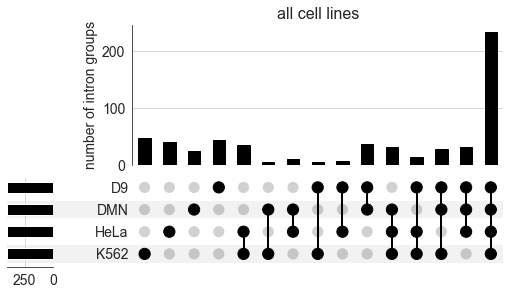

In [20]:
# Make upset plot
plot(upset_counts)

plt.title("all cell lines", fontsize=16)
plt.ylabel("number of intron groups", fontsize=14)

plt.savefig("/path/to/plots/Fig3_Upset_plot_all_cell_types.pdf", format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [21]:
# Define a category for each intron group, depending on whether all cell types show the same top order or not
path_df_all_cov = path_df_all.merge(covered_regions, on=['gene','gene_name','analyzed_introns'])
all_same_top['category'] = 'all_same'
path_df_all_cov = path_df_all_cov.merge(all_same_top, on=['gene','gene_name','analyzed_introns'], how='left').fillna('diff')

In [23]:
# Get a generic splicing order path where intron positions are replaced by relative positions within the intron group
def get_generic_path(full_path):
    
    path_split = full_path.split("->")
    path_list = [int(a) for a in path_split]
    
    ordered_introns = sorted(path_list)
    
    new_path = []
    
    for i in path_list:
        pos = ordered_introns.index(i) + 1
        new_path.append(pos)
        
    new_path_join = "->".join([str(a) for a in new_path])
        
    return(new_path_join)
    

In [24]:
# Apply above function
path_df_all_cov['generic_path'] = path_df_all_cov.apply(lambda row: get_generic_path(row.full_path), axis=1)

In [26]:
# Write to file for Supplemental Table
path_df_all_cov.to_csv("/path/to/TableS5_splicing_order_all_cell_types.txt", sep="\t", header=True, index=False)


In [24]:
# Function to calculate Shannon diversity index and Evenness
# Formulas taken from here: https://www.tutorialspoint.com/statistics/shannon_wiener_diversity_index.htm
# https://en.wikipedia.org/wiki/Species_evenness

def SDI(path_scores, max_paths):
    
    H = round(-(np.sum(np.log(path_scores) * path_scores)),2) 
    max_H = round(np.log(max_paths),2)
    
    E = round(H/max_H,2)
    
    return(E)

In [25]:
# Calculate Shannon diversity index and Evenness

cand_gene_df = path_df_all_cov[['gene','gene_name','analyzed_introns','sample_name','category']].drop_duplicates().reset_index(drop=True)

SDI_list = []

for i in tqdm(range(len(cand_gene_df))):
    gene = cand_gene_df.loc[i]['gene']
    gene_name = cand_gene_df.loc[i]['gene_name']
    analyzed_introns = cand_gene_df.loc[i]['analyzed_introns']
    sample_name = cand_gene_df.loc[i]['sample_name']
    category = cand_gene_df.loc[i]['category']
    
    path_scores = path_df_all_cov[(path_df_all_cov['gene']==gene) & (path_df_all_cov['analyzed_introns']==analyzed_introns) &
                       (path_df_all_cov['sample_name']==sample_name)]['full_path_score'].tolist()
    
    n_introns = len(analyzed_introns.split("_"))
    my_SDI = SDI(path_scores, math.factorial(n_introns))
    SDI_list.append([sample_name, gene, gene_name, analyzed_introns, my_SDI,category])
        
SDI_df = pd.DataFrame(SDI_list)
SDI_df.columns = ['sample_name','gene','gene_name','analyzed_introns','Evenness','category']

100%|██████████| 1616/1616 [00:04<00:00, 386.37it/s]


In [67]:
SDI_df.to_csv("/path/to/splicing_order_comparison_cell_types_evenness.txt", sep="\t", header=True, index=False)

In [68]:
# Make a matrix with the evenness values, separated by category
SDI_df['region'] = SDI_df['gene'] + '__' + SDI_df['analyzed_introns']
SDI_df_same = SDI_df[SDI_df['category']=='all_same'].reset_index(drop=True)
SDI_df_piv_same = SDI_df_same.pivot_table(index=['region'], columns='sample_name', values='Evenness')

SDI_df_diff = SDI_df[SDI_df['category']=='diff'].reset_index(drop=True)
SDI_df_piv_diff = SDI_df_diff.pivot_table(index=['region'], columns='sample_name', values='Evenness')

In [69]:
# Make a matrix with the splicing order scores, separated by category
path_df_all_cov['id'] = path_df_all_cov['generic_path'] + '__' + path_df_all_cov['sample_name']
path_df_all_cov['region'] = path_df_all_cov['gene'] + '__' + path_df_all_cov['analyzed_introns']

path_df_piv = path_df_all_cov.pivot_table(index=['region','category'], columns='id', values='full_path_score').fillna(0).reset_index()
path_df_piv.index = path_df_piv['region']

path_df_piv_same = path_df_piv[path_df_piv['category']=='all_same']
path_df_piv_diff = path_df_piv[path_df_piv['category']=='diff']

path_df_piv_same = path_df_piv_same.drop(columns=['region','category'])
path_df_piv_diff = path_df_piv_diff.drop(columns=['region','category'])

In [70]:
# Perform hierarchical clustering based on splicing order scores
linkage_paths_same = scipy.cluster.hierarchy.linkage(path_df_piv_same, method="average")
linkage_paths_diff = scipy.cluster.hierarchy.linkage(path_df_piv_diff, method="average")

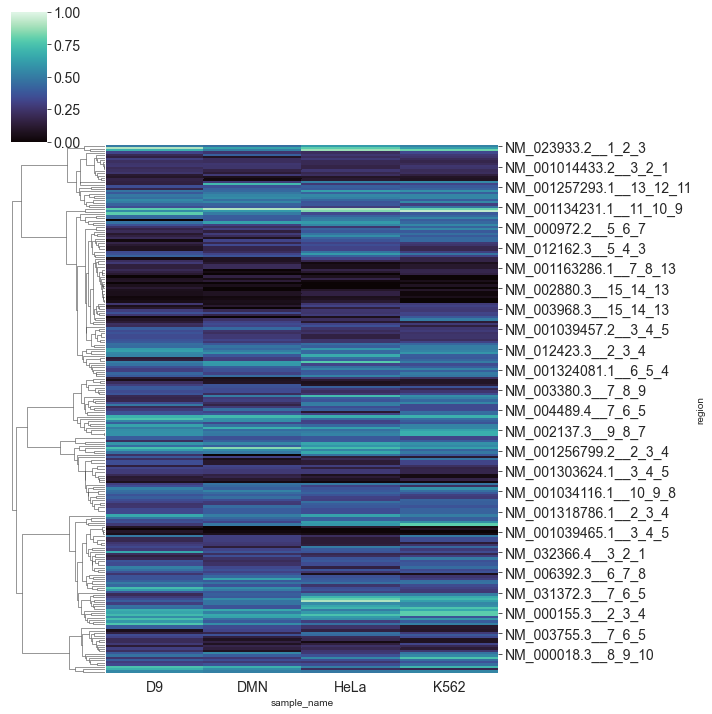

In [71]:
# Plot evenness

sns.color_palette("mako", as_cmap=True)

sns.clustermap(SDI_df_piv_same, col_cluster=False, vmin=0, vmax=1, row_linkage=linkage_paths_same, cmap="mako")

plt.savefig("/path/to/plots/Fig3_splicing_order_cell_types_heatmap_same_top_order_evenness.pdf", format='pdf', dpi=300, bbox_inches='tight')


plt.show()

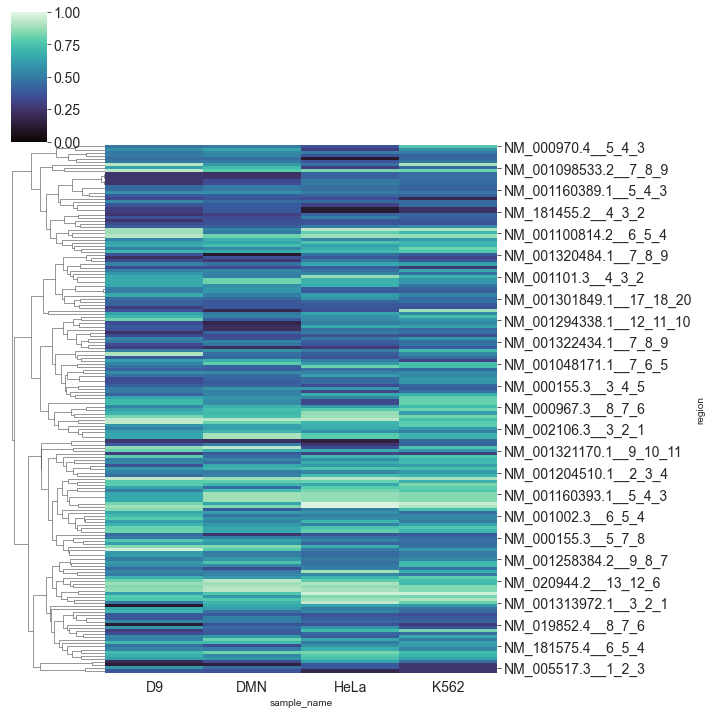

In [72]:
# Plot evenness

sns.clustermap(SDI_df_piv_diff, col_cluster=False, vmin=0, vmax=1, row_linkage=linkage_paths_diff, cmap="mako")

plt.savefig("/path/to/plots/Fig3_splicing_order_cell_types_heatmap_diff_top_order_evenness.pdf", format='pdf', dpi=300, bbox_inches='tight')


plt.show()

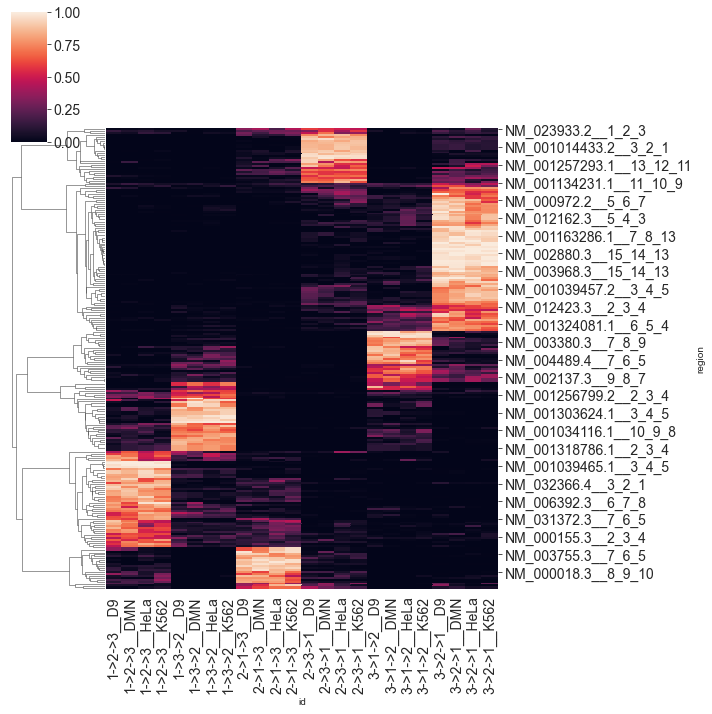

In [73]:
# Plot splicing order scores

sns.clustermap(path_df_piv_same, col_cluster=False, vmin=0, vmax=1, row_linkage=linkage_paths_same)

plt.savefig("/path/to/plots/Fig3_splicing_order_cell_types_heatmap_same_top_order.pdf", format='pdf', dpi=300, bbox_inches='tight')


plt.show()

In [74]:
len(path_df_piv_same)

234

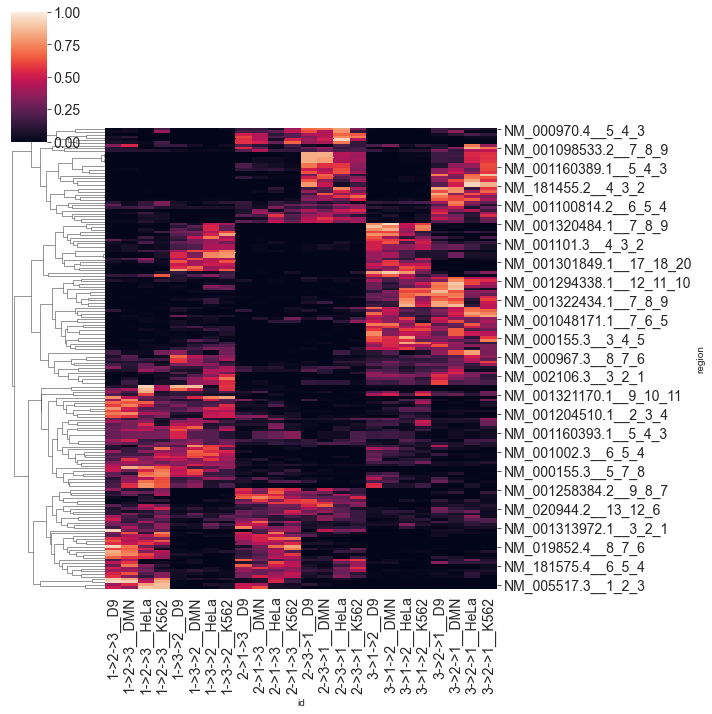

In [75]:
# Plot splicing order scores

sns.clustermap(path_df_piv_diff, col_cluster=False, vmin=0, vmax=1, row_linkage=linkage_paths_diff)

plt.savefig("/path/to/plots/Fig3_splicing_order_cell_types_heatmap_diff_top_order.pdf", format='pdf', dpi=300, bbox_inches='tight')


plt.show()

In [76]:
len(path_df_piv_diff)

170

In [80]:
# Identify intron groups with the same top ranked order for pairs of cell types

def get_common_paths_number(path_df1,path_df2):
    path_df_all = pd.concat([path_df1,path_df2]).reset_index(drop=True)
    path_df_all_piv = path_df_all[['gene_name','gene','analyzed_introns','sample_name','n_analyzed_introns']].drop_duplicates().pivot_table(index=['gene','gene_name','analyzed_introns'],columns='sample_name', values='n_analyzed_introns').dropna().reset_index()
    covered_regions = path_df_all_piv[['gene','gene_name','analyzed_introns']].drop_duplicates().reset_index(drop=True)

    path_df1_rank1 = path_df1[path_df1['rank']==1].reset_index(drop=True)
    path_df2_rank1 = path_df2[path_df2['rank']==1].reset_index(drop=True)
    
    upset_df2 = path_df1_rank1[['gene_name','gene','analyzed_introns','full_path','rank']].merge(path_df2_rank1[['gene_name','gene','analyzed_introns','full_path','rank']], on=['gene_name','gene','analyzed_introns','full_path'], how='outer').fillna(False)
    upset_df2 = upset_df2.merge(covered_regions, on=['gene_name','gene','analyzed_introns'])
    
    counts_same = len(upset_df2[upset_df2['rank_x']==upset_df2['rank_y']])
    counts_total = len(upset_df2[['gene','analyzed_introns']].drop_duplicates())
    
    freq = counts_same / counts_total
    
    return([freq, counts_total])

In [81]:
# Get frequency of intron groups with same top splicing order for each pair of cell types, and total number of intron groups analyzed
K562_vs_HeLa = get_common_paths_number(K562_path_df_nodup,HeLa_path_df_nodup)[0]
K562_vs_D9 = get_common_paths_number(K562_path_df_nodup,D9_path_df_nodup)[0]
K562_vs_D14 = get_common_paths_number(K562_path_df_nodup,D14_path_df_nodup)[0]
HeLa_vs_D9 = get_common_paths_number(HeLa_path_df_nodup,D9_path_df_nodup)[0]
HeLa_vs_D14 = get_common_paths_number(HeLa_path_df_nodup,D14_path_df_nodup)[0]
D9_vs_D14 = get_common_paths_number(D9_path_df_nodup,D14_path_df_nodup)[0]

K562_vs_HeLa_n = get_common_paths_number(K562_path_df_nodup,HeLa_path_df_nodup)[1]
K562_vs_D9_n = get_common_paths_number(K562_path_df_nodup,D9_path_df_nodup)[1]
K562_vs_D14_n = get_common_paths_number(K562_path_df_nodup,D14_path_df_nodup)[1]
HeLa_vs_D9_n = get_common_paths_number(HeLa_path_df_nodup,D9_path_df_nodup)[1]
HeLa_vs_D14_n = get_common_paths_number(HeLa_path_df_nodup,D14_path_df_nodup)[1]
D9_vs_D14_n = get_common_paths_number(D9_path_df_nodup,D14_path_df_nodup)[1]

freq_df = pd.DataFrame({'cell_type1':['K562','K562','K562','HeLa','HeLa','D9'],
                        'cell_type2':['HeLa','D9','D14','D9','D14','D14'],
                      'freq_same':[K562_vs_HeLa,K562_vs_D9,K562_vs_D14,HeLa_vs_D9,HeLa_vs_D14,D9_vs_D14],
                       'n_groups':[K562_vs_HeLa_n,K562_vs_D9_n,K562_vs_D14_n,HeLa_vs_D9_n,HeLa_vs_D14_n,D9_vs_D14_n]})


In [82]:
freq_df

,cell_type1,cell_type2,freq_same,n_groups
0,K562,HeLa,0.755102,1029
1,K562,D9,0.674973,923
2,K562,D14,0.734446,659
3,HeLa,D9,0.691099,764
4,HeLa,D14,0.743842,609
5,D9,D14,0.816514,872


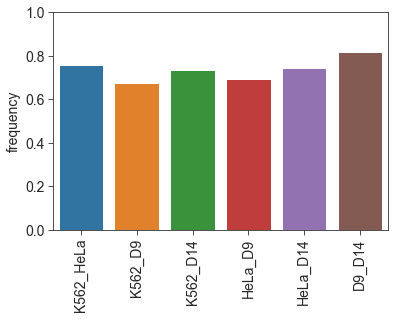

In [83]:
freq_df['cell_types'] = freq_df['cell_type1'] + '_' + freq_df['cell_type2']

sns.barplot(x='cell_types', y='freq_same', data=freq_df)

plt.ylim(0,1)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14, rotation=90)

plt.ylabel("frequency", fontsize=14)
plt.xlabel("")

plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.savefig("/path/to/plots/Fig3_pairwise_cell_type_splicing_order_comparison.pdf", format='pdf', dpi=300, bbox_inches='tight')


plt.show()